# Imports

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler

from tensorflow.keras import models, layers

# Loading data

In [146]:
laps = pd.read_csv("../raw_data/laps.csv")
track_status = pd.read_csv("../raw_data/track_status.csv")
weather = pd.read_csv("../raw_data/weather.csv")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/2337435297.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  laps = pd.read_csv("../raw_data/laps.csv")


# Put functions for testing

In [147]:
def add_race_progress(df):
    # Group data to get lap number per year per race
    grouped_data = df.groupby(by = ["Year", "Location"], as_index=False)["LapNumber"].max().rename(columns={"LapNumber":"TotalLaps"})
    grouped_data["Year_Location"] = grouped_data["Year"].map(str) + grouped_data["Location"]
    # Group data to get same info as grouped_data
    df["Year_Location"] = df["Year"].map(str) + df["Location"]
    # Merge data
    df = df.merge(grouped_data, on="Year_Location")
    # Clean data frame
    df.drop(columns=["Year_Location", "Year_y", "Location_y"], inplace=True)
    df["RaceProgress"] = df["LapNumber"] / df["TotalLaps"]
    df.rename(columns={"Location_x": "Location", "Year_x": "Year"}, inplace=True)
    return df

In [148]:
def mask_race_percentage(df, percentage):
    df = df[df["RaceProgress"] > percentage]
    return df

In [149]:
def get_tyre_stress_level(df):
    params = {'Mexico City': 4,
    'Lusail': 1,
    'Shanghai': 2,
    'Mugello': 1,
    'Hockenheim': 3,
    'Jeddah': 3,
    'Imola': 3,
    'São Paulo': 3,
    'Montréal': 3,
    'Singapore': 4,
    'Marina Bay': 4,
    'Barcelona': 1,
    'Spain': 1,
    'Spa-Francorchamps': 1,
    'Spielberg': 3,
    'Melbourne': 3,
    'Budapest': 3,
    'Nürburgring': 3,
    'Suzuka': 1,
    'Austin': 1,
    'Zandvoort': 1,
    'Bahrain': 3,
    'Portimão': 2,
    'Sochi': 4,
    'Monza': 1,
    'Yas Marina': 3,
    'Monaco': 5,
    'Miami': 3,
    'Istanbul': 1,
    'Baku': 3,
    'Monte Carlo': 5,
    'Yas Island': 3,
    'Le Castellet': 2,
    'Sakhir': 3,
    'Silverstone': 1}
    df["TyreStressLevel"] = df["Location"].map(params)
    return df


In [150]:
TIRE_MATCH = {
    'HYPERSOFT': 'SOFT',
    'ULTRASOFT': 'SOFT',
    'SUPERSOFT': 'SOFT',
    'SOFT': 'SOFT',
    'MEDIUM': 'MEDIUM',
    'HARD': 'HARD',
    'INTERMEDIATE': 'INTERMEDIATE',
    'WET': 'WET',
    'UNKNOWN': 'UNKNOWN'
}
def compound_recategorization(laps,tire_mapping):
    new_laps = laps.copy()
    new_laps['Compound']=laps['Compound'].map(tire_mapping)
    return new_laps

In [151]:
def compound_cleaning(laps,tire_mapping,backfilling=3):
    new_laps = laps.copy()
    new_laps = compound_recategorization(new_laps,tire_mapping)
    new_laps['Compound'].replace('UNKNOWN',None,inplace=True)
    new_laps['Compound'].fillna(method="bfill",limit=backfilling,inplace=True)
    return new_laps

In [152]:
def pitting(df):
    df['pitting_this_lap'] = np.where(laps['PitInTime'].notna(), True, False)
    return df

# Apply functions on laps data

In [153]:
laps = compound_recategorization(laps, TIRE_MATCH)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,0 days 00:07:07.988000,NaN,1.0,17.0,False,NaN,False,False,Melbourne,2018
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,0 days 00:08:53.241000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,0 days 00:10:26.613000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,0 days 00:11:59.474000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,0 days 00:13:31.658000,NaN,2.0,17.0,False,NaN,False,True,Melbourne,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,0 days 02:24:21.766000,2023-06-04 14:25:21.773,1.0,20.0,False,NaN,False,True,Barcelona,2023
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,0 days 02:25:43.046000,2023-06-04 14:26:43.053,1.0,20.0,False,NaN,False,True,Barcelona,2023
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,0 days 02:27:05.180000,2023-06-04 14:28:05.187,1.0,20.0,False,NaN,False,True,Barcelona,2023
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,0 days 02:28:25.600000,2023-06-04 14:29:25.607,1.0,20.0,False,NaN,False,True,Barcelona,2023


In [154]:
laps = add_race_progress(laps)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,1.0,17.0,False,NaN,False,False,Melbourne,2018,58.0,0.017241
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.034483
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.051724
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.068966
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,2.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.086207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [155]:
laps = compound_cleaning(laps, TIRE_MATCH)

In [156]:
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,1.0,17.0,False,NaN,False,False,Melbourne,2018,58.0,0.017241
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.034483
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.051724
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.068966
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,2.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.086207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [157]:
laps = mask_race_percentage(laps, 0.1)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
5,5,0 days 00:16:42.170000,GAS,10,0 days 00:01:38.180000,6.0,1.0,NaN,NaN,0 days 00:00:30.866000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.103448
6,6,0 days 00:18:13.707000,GAS,10,0 days 00:01:31.537000,7.0,1.0,NaN,NaN,0 days 00:00:30.529000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.120690
7,7,0 days 00:19:45.026000,GAS,10,0 days 00:01:31.319000,8.0,1.0,NaN,NaN,0 days 00:00:30.438000,...,1.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.137931
8,8,0 days 00:21:16.167000,GAS,10,0 days 00:01:31.141000,9.0,1.0,NaN,NaN,0 days 00:00:30.515000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.155172
9,9,0 days 00:22:47.303000,GAS,10,0 days 00:01:31.136000,10.0,1.0,NaN,NaN,0 days 00:00:30.548000,...,1.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.172414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [158]:
laps = get_tyre_stress_level(laps)
laps

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/4032226164.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TyreStressLevel"] = df["Location"].map(params)


,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress,TyreStressLevel
5,5,0 days 00:16:42.170000,GAS,10,0 days 00:01:38.180000,6.0,1.0,NaN,NaN,0 days 00:00:30.866000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.103448,3
6,6,0 days 00:18:13.707000,GAS,10,0 days 00:01:31.537000,7.0,1.0,NaN,NaN,0 days 00:00:30.529000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.120690,3
7,7,0 days 00:19:45.026000,GAS,10,0 days 00:01:31.319000,8.0,1.0,NaN,NaN,0 days 00:00:30.438000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.137931,3
8,8,0 days 00:21:16.167000,GAS,10,0 days 00:01:31.141000,9.0,1.0,NaN,NaN,0 days 00:00:30.515000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.155172,3
9,9,0 days 00:22:47.303000,GAS,10,0 days 00:01:31.136000,10.0,1.0,NaN,NaN,0 days 00:00:30.548000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.172414,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242,1
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394,1
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545,1
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697,1


In [159]:
laps = pitting(laps)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/3543978339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitting_this_lap'] = np.where(laps['PitInTime'].notna(), True, False)


# Drop columns

In [162]:
laps.columns

Index(['Unnamed: 0', 'Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
       'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team',
       'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate', 'Location', 'Year',
       'TotalLaps', 'RaceProgress', 'TyreStressLevel', 'pitting_this_lap'],
      dtype='object')

In [164]:
laps.drop(columns=['Unnamed: 0', 'Time', 'DriverNumber', 'LapTime',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
       'LapStartTime', 'LapStartDate', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate'], inplace = True)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/3968897646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps.drop(columns=['Unnamed: 0', 'Time', 'DriverNumber', 'LapTime',


# NaN management

In [166]:
# Driver à checker à la main ✅
# SpeedI1 / SpeedI2 / SpeedFL / SpeedST à supprimer ✅
# IsPersonalBest = most frequent ✅
# Compound à checker à la main 
# Team à checker à la main 
# TrackStatus à checker à la main 
# Position à checker à la main 

In [172]:
laps["Driver"] = laps["Driver"].fillna("OCO")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/1099988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["Driver"] = laps["Driver"].fillna("OCO")


In [175]:
laps["IsPersonalBest"] = laps["IsPersonalBest"].fillna(False)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_47724/1618413017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["IsPersonalBest"] = laps["IsPersonalBest"].fillna(False)


In [161]:
laps.isna().sum() / len(laps)

Unnamed: 0            0.000000
Time                  0.000000
Driver                0.000548
DriverNumber          0.000000
LapTime               0.014631
LapNumber             0.000000
Stint                 0.000000
PitOutTime            0.968194
PitInTime             0.967363
Sector1Time           0.003066
Sector2Time           0.001873
Sector3Time           0.003163
Sector1SessionTime    0.005743
Sector2SessionTime    0.001873
Sector3SessionTime    0.003163
SpeedI1               0.148154
SpeedI2               0.002129
SpeedFL               0.034836
SpeedST               0.084860
IsPersonalBest        0.001414
Compound              0.000239
TyreLife              0.000000
FreshTyre             0.000000
Team                  0.000548
LapStartTime          0.000000
LapStartDate          0.016769
TrackStatus           0.001414
Position              0.001414
Deleted               0.000000
DeletedReason         0.993939
FastF1Generated       0.000000
IsAccurate            0.000000
Location

In [106]:
laps

,Driver,LapNumber,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Location,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
5,GAS,6.0,262.0,283.0,277.0,284.0,False,SOFT,5.0,True,Toro Rosso,2.0,16.0,Melbourne,58.0,0.103448,3,False
6,GAS,7.0,265.0,275.0,278.0,NaN,True,SOFT,6.0,True,Toro Rosso,2.0,16.0,Melbourne,58.0,0.120690,3,False
7,GAS,8.0,264.0,274.0,280.0,272.0,True,SOFT,7.0,True,Toro Rosso,1.0,16.0,Melbourne,58.0,0.137931,3,False
8,GAS,9.0,263.0,276.0,278.0,280.0,True,SOFT,8.0,True,Toro Rosso,2.0,16.0,Melbourne,58.0,0.155172,3,False
9,GAS,10.0,264.0,279.0,279.0,282.0,True,SOFT,9.0,True,Toro Rosso,1.0,16.0,Melbourne,58.0,0.172414,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,SAR,61.0,265.0,265.0,280.0,306.0,False,HARD,25.0,True,Williams,1.0,20.0,Barcelona,66.0,0.924242,1,False
125755,SAR,62.0,271.0,192.0,280.0,308.0,False,HARD,26.0,True,Williams,1.0,20.0,Barcelona,66.0,0.939394,1,False
125756,SAR,63.0,264.0,273.0,280.0,310.0,False,HARD,27.0,True,Williams,1.0,20.0,Barcelona,66.0,0.954545,1,False
125757,SAR,64.0,279.0,278.0,280.0,308.0,False,HARD,28.0,True,Williams,1.0,20.0,Barcelona,66.0,0.969697,1,False


# Set X & y

In [130]:
# TODO:
# Quid du Y ? => Fill NaN by 0 and not NaN by 1 OK 
# Quid du X ? OK 
# Train test split x2 pour val 
# Pipeline => tout dedans 
# Scaling des données fit train transform train val test 
# Pipeline sur le OHE 
# Quid du rebalancing ?

# Preproc (OHE encoder / Scaling) - Pipeline
# TTS 
# SMOTE - Pipeline


# Séparation X & y 
# Train test val split
# Preproc la donnée avec OHE + Scaling  
# SMOTE sur Train 

In [108]:
y = laps["pitting_this_lap"]

In [109]:
X = laps.drop(columns="pitting_this_lap")

# Train Test Val Split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [111]:
y_train.shape, y_test.shape

((96208,), (16978,))

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [113]:
y_train.shape, y_val.shape

((76966,), (19242,))

# Preprocessing

In [114]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

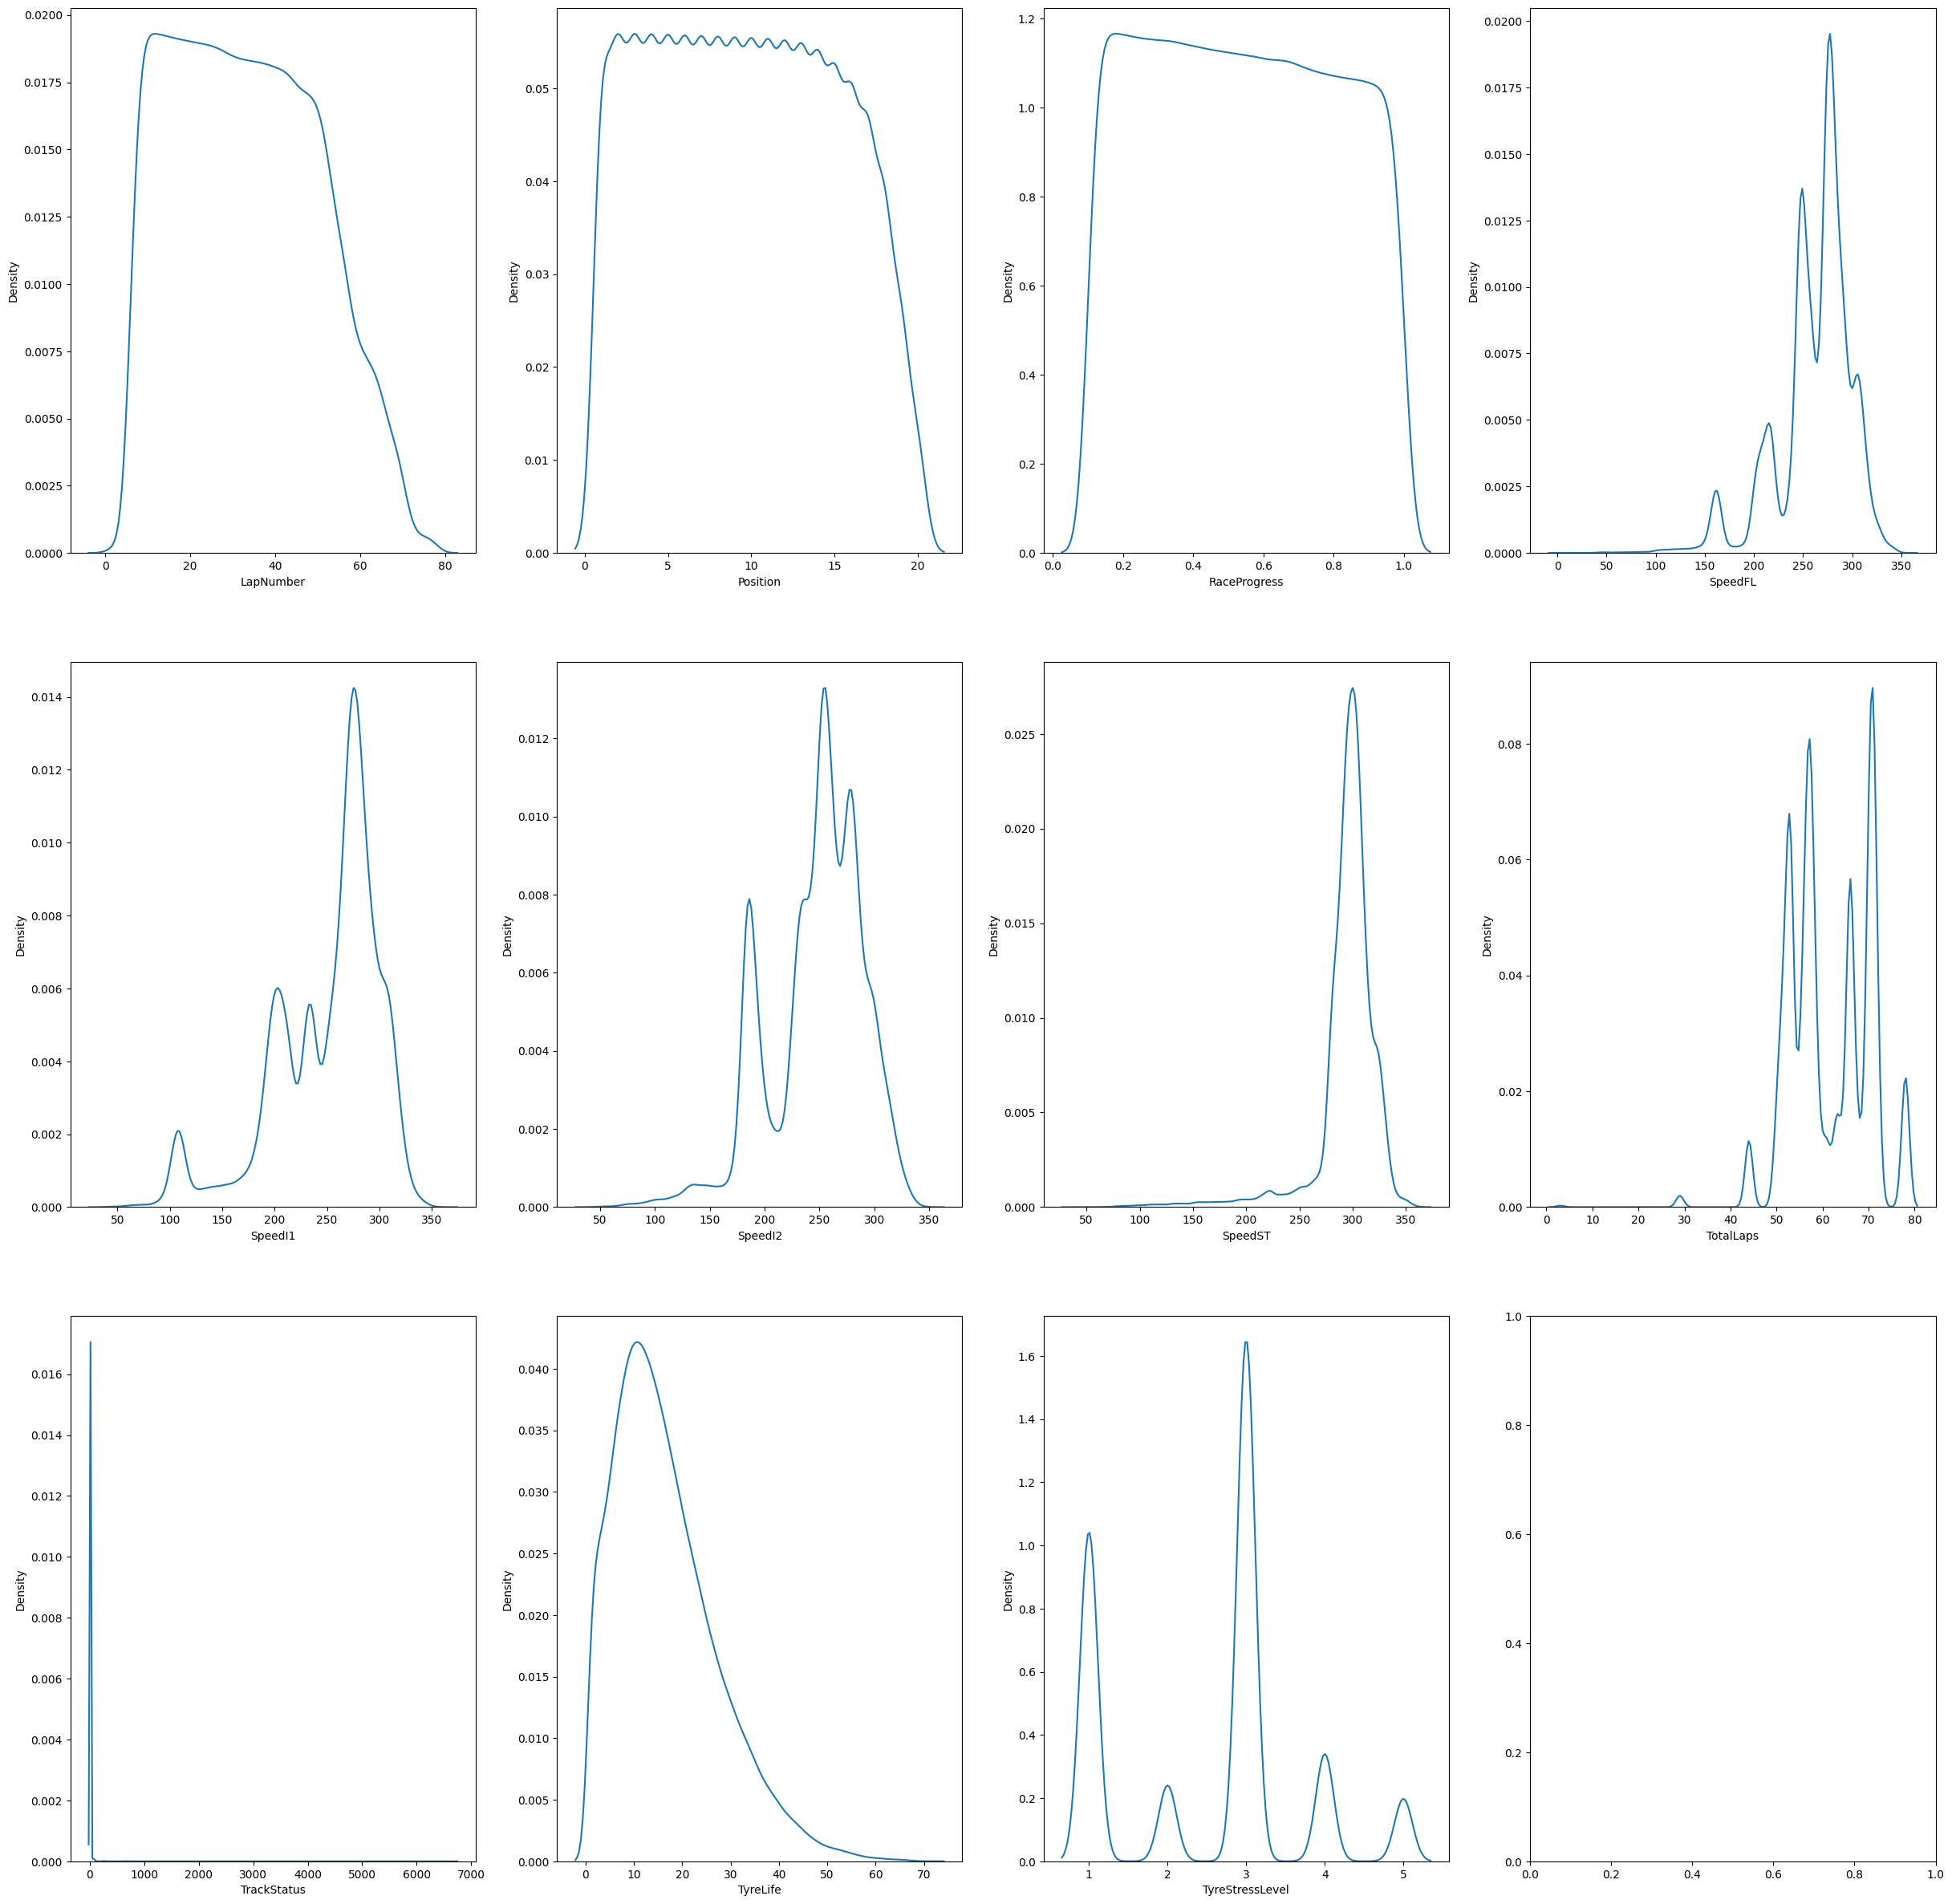

In [115]:
fig, axs = plt.subplots(3,4, figsize=(30, 30))

axs = axs.ravel()

for ax, column in zip(axs, feat_numerical):
    sns.kdeplot(x=column, data=X, ax=ax)

In [116]:
X.columns

Index(['Driver', 'LapNumber', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
       'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team',
       'TrackStatus', 'Position', 'Location', 'TotalLaps', 'RaceProgress',
       'TyreStressLevel'],
      dtype='object')

In [117]:
X.dtypes

Driver              object
LapNumber          float64
SpeedI1            float64
SpeedI2            float64
SpeedFL            float64
SpeedST            float64
IsPersonalBest      object
Compound            object
TyreLife           float64
FreshTyre             bool
Team                object
TrackStatus        float64
Position           float64
Location            object
TotalLaps          float64
RaceProgress       float64
TyreStressLevel      int64
dtype: object

In [118]:
cat_features = ["Driver", "Compound", "Team", "IsPersonalBest", "FreshTyre", "Location"]
cat_features_preproc = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))
num_features = ["LapNumber", "SpeedI1", "SpeedI2", "SpeedFL", "SpeedST", "TyreLife", "TrackStatus", "Position", "TotalLaps", "TyreStressLevel"]
num_features_preproc = make_pipeline(RobustScaler())

In [119]:
preproc_baseline = make_column_transformer((cat_features_preproc, cat_features),
                                           (num_features_preproc, num_features),
                                           remainder="passthrough")

In [120]:
preproc_baseline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Driver', 'Compound', 'Team',
                                  'IsPersonalBest', 'FreshTyre', 'Location']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['LapNumber', 'SpeedI1', 'SpeedI2', 'SpeedFL',
                                  'SpeedST', 'TyreLife', 'TrackStatus',
                                  'Position', 'TotalLaps',
                                  'TyreStressLevel'])])

In [121]:
preproc_baseline.fit(X_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_test_preproc = preproc_baseline.transform(X_test)
X_val_preproc = preproc_baseline.transform(X_val)

/Users/etienneginoux/.pyenv/versions/3.10.6/envs/f1-binottor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# SMOTE & Tomek

In [122]:
smt = SMOTETomek(sampling_strategy=0.3)
X_train_preproc_resamp, y_train_resamp = smt.fit_resample(X_train_preproc, y_train)

ValueError: Input X contains NaN.
SMOTETomek does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values